
# SDCND Project 3: Behavioral Cloning

---

### Read in CSV file

In [1]:
import csv
import numpy as np
import cv2
import os
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt


# store list of data
samples = []

# choose which driving data folder to use
FOLDERNAME = 'data'

# Read in image directory and steering angles from CSV file 
with open(FOLDERNAME+'/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

### Download images and corresponding steering angles
#### Preprocessing: CROP, RESIZE, CLAHE
#### Augmentation: SHEAR

In [2]:
# store array of images
car_images = []

# store list of angles
steering_angles = []

## Pre-Processing: crop, resize, CLAHE
## This preprocessing is done in the drive.py code also before input images are fed into deep learning model 
def preprocessing(img):
    outim = img[60:138,0:320]
    outim = cv2.resize(outim,(64,64))
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(10,10))
    outim = clahe.apply(outim)
    return outim

## Augmentation: Shear
## If h == True, input image is sheared such that the lateral position of the car stays the same but the yaw angle differs
## If h == False, input image is sheared such that the yaw angle stays the same but the lateral position of the car differs
def shear(img,shift,h):
    if h == True: 
        pts1 = np.float32([[0,64],[64,64],[32,0]])
        pts2 = np.float32([[0,64],[64,64],[32+shift,0]])
    else:
        pts1 = np.float32([[64,0],[0,0],[32,64]])
        pts2 = np.float32([[64,0],[0,0],[32+shift,64]])
    M = cv2.getAffineTransform(pts1,pts2)
    newim = cv2.warpAffine(img, M, (64,64),borderMode=cv2.BORDER_REPLICATE)
    return newim

### Here batch size is set, but as images are augmented, the final batch size became BATCH_SIZE*(# of augmented images))
''' 
PARAMETER to TUNE 
'''
BATCH_SIZE = 32 

### Deep learning model inputs generator 
def generator(samples, batch_size = BATCH_SIZE):
    num_samples = len(samples)
    while 1:
        
        # shuffle data
        shuffle(samples)
        
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            car_images = []       # X_train
            steering_angles = []  # y_train

            for batch_sample in batch_samples:

                # read images from center, left, and right cameras IN GRAYSCALE 
                im_c = cv2.imread(FOLDERNAME+'/IMG/'+ batch_sample[0].split('/')[-1],0)
                im_c = preprocessing(im_c)
                im_l = cv2.imread(FOLDERNAME+'/IMG/'+ batch_sample[1].split('/')[-1],0)
                im_l = preprocessing(im_l)
                im_r = cv2.imread(FOLDERNAME+'/IMG/'+ batch_sample[2].split('/')[-1],0)
                im_r = preprocessing(im_r)

                # adjusted steering measurements for the left and right camera images
                ''' 
                PARAMETER to TUNE 
                '''                
                correction = 0.2  

                st_c = float(line[3])
                st_l = st_c+correction
                st_r = st_c-correction

                # add raw images from center, left, and right camera
                # add raw angle for center image, and add modified angle fro left and right
                car_images.append(im_c)
                steering_angles.append(st_c)
                car_images.append(im_l)
                steering_angles.append(st_l)
                car_images.append(im_r)
                steering_angles.append(st_r)
                
                # add flipped images 
                # add flipped angles (the sign has changed by multiplying by -1.0) 
                car_images.append(cv2.flip(im_c,1))
                steering_angles.append(st_c*-1.0)
                car_images.append(cv2.flip(im_l,1))
                steering_angles.append(st_l*-1.0)
                car_images.append(cv2.flip(im_r,1))
                steering_angles.append(st_r*-1.0)
                
                ### shear
                # add sheared images
                # add modified angles (angle + shift*angle_coeff)
                # same lateral position on the road, different yaw angle
                ''' 
                PARAMETER to TUNE 
                '''            
                angle_coeff = 0.02 
                shift = 20.
                car_images.append(shear(im_c,shift,True))
                steering_angles.append(st_c+shift*angle_coeff)
                car_images.append(shear(im_l,shift,True))
                steering_angles.append(st_l+shift*angle_coeff)
                car_images.append(shear(im_r,shift,True))
                steering_angles.append(st_r+shift*angle_coeff)
                shift = -20.
                car_images.append(shear(im_c,shift,True))
                steering_angles.append(st_c+shift*angle_coeff)
                car_images.append(shear(im_l,shift,True))
                steering_angles.append(st_l+shift*angle_coeff)
                car_images.append(shear(im_r,shift,True))
                steering_angles.append(st_r+shift*angle_coeff) 
                shift = 10.
                car_images.append(shear(im_c,shift,True))
                steering_angles.append(st_c+shift*angle_coeff)
                car_images.append(shear(im_l,shift,True))
                steering_angles.append(st_l+shift*angle_coeff)
                car_images.append(shear(im_r,shift,True))
                steering_angles.append(st_r+shift*angle_coeff)
                shift = -10.
                car_images.append(shear(im_c,shift,True))
                steering_angles.append(st_c+shift*angle_coeff)
                car_images.append(shear(im_l,shift,True))
                steering_angles.append(st_l+shift*angle_coeff)
                car_images.append(shear(im_r,shift,True))
                steering_angles.append(st_r+shift*angle_coeff)
                angle_coeff = 0.02
                shift = 5.
                car_images.append(shear(im_c,shift,True))
                steering_angles.append(st_c+shift*angle_coeff)
                car_images.append(shear(im_l,shift,True))
                steering_angles.append(st_l+shift*angle_coeff)
                car_images.append(shear(im_r,shift,True))
                steering_angles.append(st_r+shift*angle_coeff)
                shift = -5.
                car_images.append(shear(im_c,shift,True))
                steering_angles.append(st_c+shift*angle_coeff)
                car_images.append(shear(im_l,shift,True))
                steering_angles.append(st_l+shift*angle_coeff)
                car_images.append(shear(im_r,shift,True))
                steering_angles.append(st_r+shift*angle_coeff)  
                shift = 3.
                car_images.append(shear(im_c,shift,True))
                steering_angles.append(st_c+shift*angle_coeff)
                car_images.append(shear(im_l,shift,True))
                steering_angles.append(st_l+shift*angle_coeff)
                car_images.append(shear(im_r,shift,True))
                steering_angles.append(st_r+shift*angle_coeff)
                shift = -3.
                car_images.append(shear(im_c,shift,True))
                steering_angles.append(st_c+shift*angle_coeff)
                car_images.append(shear(im_l,shift,True))
                steering_angles.append(st_l+shift*angle_coeff)
                car_images.append(shear(im_r,shift,True))
                steering_angles.append(st_r+shift*angle_coeff)               
                
                ### shear
                # add sheared images
                # add modified angles (angle + shift*angle_coeff)
                # same yaw angle, different lateral position on the road
                # modify left camera images to create further left perspective images 
                # modify right camera images to create further right perspective images
                ''' 
                PARAMETER to TUNE 
                '''
                angle_coeff = 0.005 
                shift = 5.
                car_images.append(shear(im_l,shift,False))
                steering_angles.append(st_l+shift*angle_coeff)
                car_images.append(shear(cv2.flip(im_r,1),shift,False))
                steering_angles.append(st_r*-1.0+shift*angle_coeff)
                shift = -5.
                car_images.append(shear(im_r,shift,False))
                steering_angles.append(st_r+shift*angle_coeff)
                car_images.append(shear(cv2.flip(im_l,1),shift,False))
                steering_angles.append(st_l*-1.0+shift*angle_coeff)
                shift = 10.
                car_images.append(shear(im_l,shift,False))
                steering_angles.append(st_l+shift*angle_coeff)
                car_images.append(shear(cv2.flip(im_r,1),shift,False))
                steering_angles.append(st_r*-1.0+shift*angle_coeff)
                shift = -10.
                car_images.append(shear(im_r,shift,False))
                steering_angles.append(st_r+shift*angle_coeff)
                car_images.append(shear(cv2.flip(im_l,1),shift,False))
                steering_angles.append(st_l*-1.0+shift*angle_coeff)
                shift = 20.
                car_images.append(shear(im_l,shift,False))
                steering_angles.append(st_l+shift*angle_coeff)
                car_images.append(shear(cv2.flip(im_r,1),shift,False))
                steering_angles.append(st_r*-1.0+shift*angle_coeff)
                shift = -20.
                car_images.append(shear(im_r,shift,False))
                steering_angles.append(st_r+shift*angle_coeff)
                car_images.append(shear(cv2.flip(im_l,1),shift,False))
                steering_angles.append(st_l*-1.0+shift*angle_coeff)
                
            # pass input data to deep learning model 
            ''' 
            CHANGE according to number of augmented images created 
            '''
            duplicated = 42 
            X_train = np.array(car_images).reshape((len(batch_samples)*duplicated,64,64,1))
            y_train = np.array(steering_angles)
            yield sklearn.utils.shuffle(X_train, y_train)

# compile and train the model using the generator function
train_samples, validation_samples = train_test_split(samples, test_size = 0.2)
train_generator = generator(train_samples, batch_size=BATCH_SIZE)
validation_generator = generator(validation_samples, batch_size=BATCH_SIZE)

print('Done')

Done


### Define model

In [3]:
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.advanced_activations import ELU
import tensorflow as tf

model = Sequential()

# normalize
model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape = (64,64,1)))

# Conv Layer 1
model.add(Conv2D(6,(5,5),strides=(2,2)))
model.add(ELU())

# Conv Layer 2
model.add(Conv2D(12,(5,5),strides=2))
model.add(ELU())

# Conv Layer 3
model.add(Conv2D(24,(5,5),strides=2))
model.add(ELU())

# Conv Layer 4
model.add(Conv2D(36,(3,3),strides=1))
model.add(ELU())

model.add(Flatten())

# dropout
model.add(Dropout(0.2))

# Fully Connected Layer 1
model.add(Dense(120))
model.add(ELU())

# Fully Connected Layer 2
model.add(Dense(84))
model.add(ELU())

# Fully Connected Layer 3
model.add(Dense(1))

print('Done')

Using TensorFlow backend.


Done


### Start training

Epoch 1/3
26/26 [==============================] - 43s - loss: 0.0498 - val_loss: 0.0377

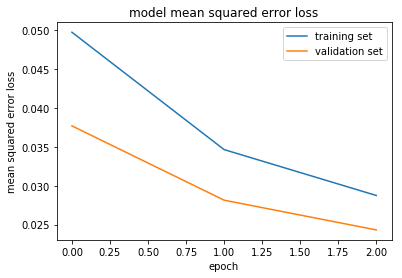

Done


In [4]:

# cost function: mean square error
# optimmizer: ADAM oprimizer
model.compile(loss='mse', optimizer='adam')

# model.fit_generator
history_object = model.fit_generator(train_generator,
steps_per_epoch=np.uint8(len(train_samples)/BATCH_SIZE), validation_data=validation_generator,
            validation_steps=np.uint8(len(validation_samples)/BATCH_SIZE), epochs=3, verbose=1)


### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

### save the model 
model.save('track2_model.h5')

print('Done')

### Vidualizations of Images and Angles

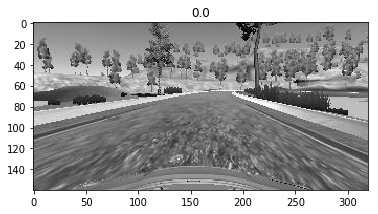

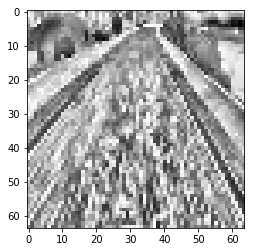

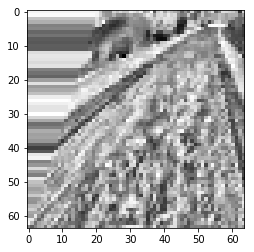

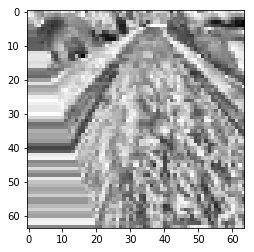

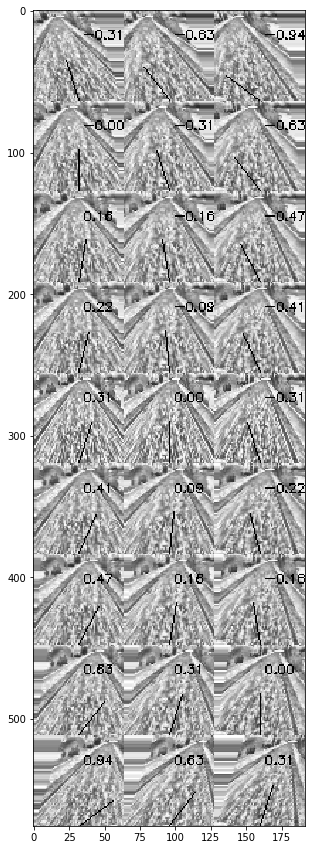

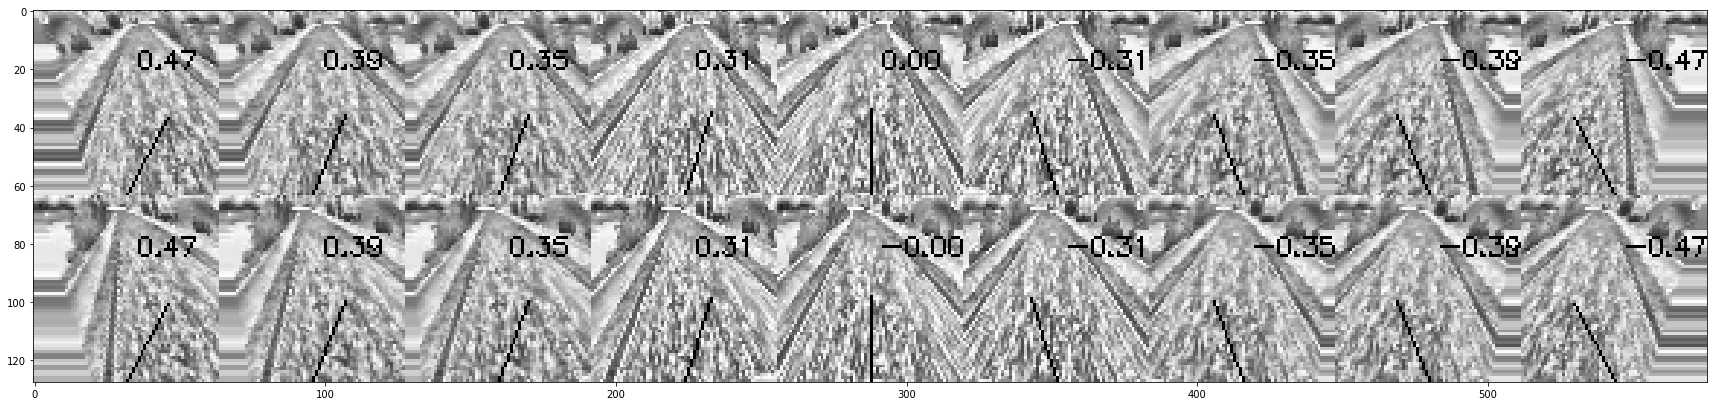

In [4]:
import csv
import numpy as np
import cv2
import os
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

# process crop, resize, CLAHE
def preprocessing(img):
    outim = img[60:138,0:320]
    outim = cv2.resize(outim,(64,64))
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(10,10))
    outim = clahe.apply(outim)
    return outim

## Shear
def shear(img,shift,h):
    if h == True: 
        pts1 = np.float32([[0,64],[64,64],[32,0]])
        pts2 = np.float32([[0,64],[64,64],[32+shift,0]])
    else:
        pts1 = np.float32([[64,0],[0,0],[32,64]])
        pts2 = np.float32([[64,0],[0,0],[32+shift,64]])
    M = cv2.getAffineTransform(pts1,pts2)
    newim = cv2.warpAffine(img, M, (64,64),borderMode=cv2.BORDER_REPLICATE) 
    return newim

samples = []
FILENAME = 'data'

with open(FILENAME+'/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

INDEX = 1000
        
# read images from center, left, and right cameras
im_c = cv2.imread(FILENAME+'/IMG/'+ samples[INDEX][0].split('/')[-1],0)
im_l = cv2.imread(FILENAME+'/IMG/'+ samples[INDEX][1].split('/')[-1],0)
im_r = cv2.imread(FILENAME+'/IMG/'+ samples[INDEX][2].split('/')[-1],0)

correction = 0.2
st_c = np.float16(samples[INDEX][3])
st_l = np.float16(st_c+correction)
st_r = np.float16(st_c-correction)

plt.imshow(im_c,cmap='gray')
plt.title(st_c)
plt.show()
plt.imshow(preprocessing(im_c),cmap='gray')
plt.show()
plt.imshow(shear(preprocessing(im_c),20,True),cmap='gray')
plt.show()
plt.imshow(shear(preprocessing(im_c),20,False),cmap='gray')
plt.show()

im_c = preprocessing(im_c)
im_l = preprocessing(im_l)
im_r = preprocessing(im_r)


def angle(img,angle):
    # add a line to show the steering angle output
    newim = img.copy()
    st_angle = angle/0.0111*(3.14/180)
    line_length = 30
    P1 = (32,64)
    P2 = (np.int8(np.round(32+line_length*np.sin(st_angle))),np.int8(np.round(64-line_length*np.cos(st_angle))))
    newim = cv2.line(newim,P1,P2,0,thickness=1)
    newim = cv2.putText(newim, str("{:.2f}".format(st_angle)),(35,20),cv2.FONT_HERSHEY_SIMPLEX,0.3,0,thickness=1)
    return newim

fig, ax = plt.subplots(nrows=1, ncols=1 ,figsize=(30,15))

im_row0 = np.concatenate(
    [angle(im_l,st_l),
     angle(im_c,st_c),
     angle(im_r,st_r)],axis=1)

angle_coeff = 0.02
shift = -20.
im_row3 = np.concatenate([angle((shear(im_l,shift,True)),(st_l+shift*angle_coeff)),
                          angle((shear(im_c,shift,True)),(st_c+shift*angle_coeff)),
                          angle((shear(im_r,shift,True)),(st_r+shift*angle_coeff))],axis=1)
shift = -10.
im_row4 = np.concatenate([angle((shear(im_l,shift,True)),(st_l+shift*angle_coeff)),
                          angle((shear(im_c,shift,True)),(st_c+shift*angle_coeff)),
                          angle((shear(im_r,shift,True)),(st_r+shift*angle_coeff))],axis=1)
shift = -5.
im_row5 = np.concatenate([angle((shear(im_l,shift,True)),(st_l+shift*angle_coeff)),
                          angle((shear(im_c,shift,True)),(st_c+shift*angle_coeff)),
                          angle((shear(im_r,shift,True)),(st_r+shift*angle_coeff))],axis=1)
shift = -3.
im_row6 = np.concatenate([angle((shear(im_l,shift,True)),(st_l+shift*angle_coeff)),
                          angle((shear(im_c,shift,True)),(st_c+shift*angle_coeff)),
                          angle((shear(im_r,shift,True)),(st_r+shift*angle_coeff))],axis=1)
shift = 3.
im_row7 = np.concatenate([angle((shear(im_l,shift,True)),(st_l+shift*angle_coeff)),
                          angle((shear(im_c,shift,True)),(st_c+shift*angle_coeff)),
                          angle((shear(im_r,shift,True)),(st_r+shift*angle_coeff))],axis=1)
shift = 5.
im_row8 = np.concatenate([angle((shear(im_l,shift,True)),(st_l+shift*angle_coeff)),
                           angle((shear(im_c,shift,True)),(st_c+shift*angle_coeff)),
                           angle((shear(im_r,shift,True)),(st_r+shift*angle_coeff))],axis=1)
shift = 10.
im_row9 = np.concatenate([angle((shear(im_l,shift,True)),(st_l+shift*angle_coeff)),
                          angle((shear(im_c,shift,True)),(st_c+shift*angle_coeff)),
                          angle((shear(im_r,shift,True)),(st_r+shift*angle_coeff))],axis=1)
shift = 20.
im_row10 = np.concatenate([angle((shear(im_l,shift,True)),(st_l+shift*angle_coeff)),
                          angle((shear(im_c,shift,True)),(st_c+shift*angle_coeff)),
                          angle((shear(im_r,shift,True)),(st_r+shift*angle_coeff))],axis=1)                       

im_show = np.concatenate([im_row3,im_row4,im_row5,im_row6,im_row0,im_row7,im_row8,im_row9,im_row10],axis=0)
plt.imshow(im_show,cmap='gray')
plt.show()


fig, ax = plt.subplots(nrows=1, ncols=1 ,figsize=(30,15))

im_row1 = np.concatenate(
    [angle(im_l,st_l),
     angle(im_c,st_c),
     angle(im_r,st_r)],axis=1)

im_row2 = np.concatenate(
    [angle(cv2.flip(im_r,1),st_r*-1.0),
     angle(cv2.flip(im_c,1),st_c*-1.0),
     angle(cv2.flip(im_l,1),st_l*-1.0)],axis=1)

angle_coeff = 0.005
im_row11 = np.concatenate([angle((shear(im_l,20,False)),(st_l+20*angle_coeff)),
                           angle((shear(im_l,10,False)),(st_l+10*angle_coeff)),
                           angle((shear(im_l,5,False)),(st_l+5*angle_coeff))],axis=1)
im_row12 = np.concatenate([angle((shear(im_r,-5,False)),(st_r-5*angle_coeff)),
                           angle((shear(im_r,-10,False)),(st_r-10*angle_coeff)),
                           angle((shear(im_r,-20,False)),(st_r-20*angle_coeff))],axis=1) 

im_row13 = np.concatenate([angle((shear(cv2.flip(im_r,1),20,False)),(st_r*-1.0+20*angle_coeff)),
                           angle((shear(cv2.flip(im_r,1),10,False)),(st_r*-1.0+10*angle_coeff)),
                           angle((shear(cv2.flip(im_r,1),5,False)),(st_r*-1.0+5*angle_coeff))],axis=1)
im_row14 = np.concatenate([angle((shear(cv2.flip(im_l,1),-5,False)),(st_l*-1.0-5*angle_coeff)),
                           angle((shear(cv2.flip(im_l,1),-10,False)),(st_l*-1.0-10*angle_coeff)),
                           angle((shear(cv2.flip(im_l,1),-20,False)),(st_l*-1.0-20*angle_coeff))],axis=1) 

im_show = np.concatenate([im_row11,im_row1,im_row12],axis=1)
im_show_flip = np.concatenate([im_row13,im_row2,im_row14],axis=1)
im_show = np.concatenate([im_show,im_show_flip],axis=0)
plt.imshow(im_show,cmap='gray')
plt.show()


In [2]:
print(len(samples))

8037
